In [127]:
import numpy as np
from math import sin, cos, pi
import matplotlib.pyplot as plt
from scipy.stats import qmc
import yfinance as yf
from datetime import datetime
%matplotlib widget

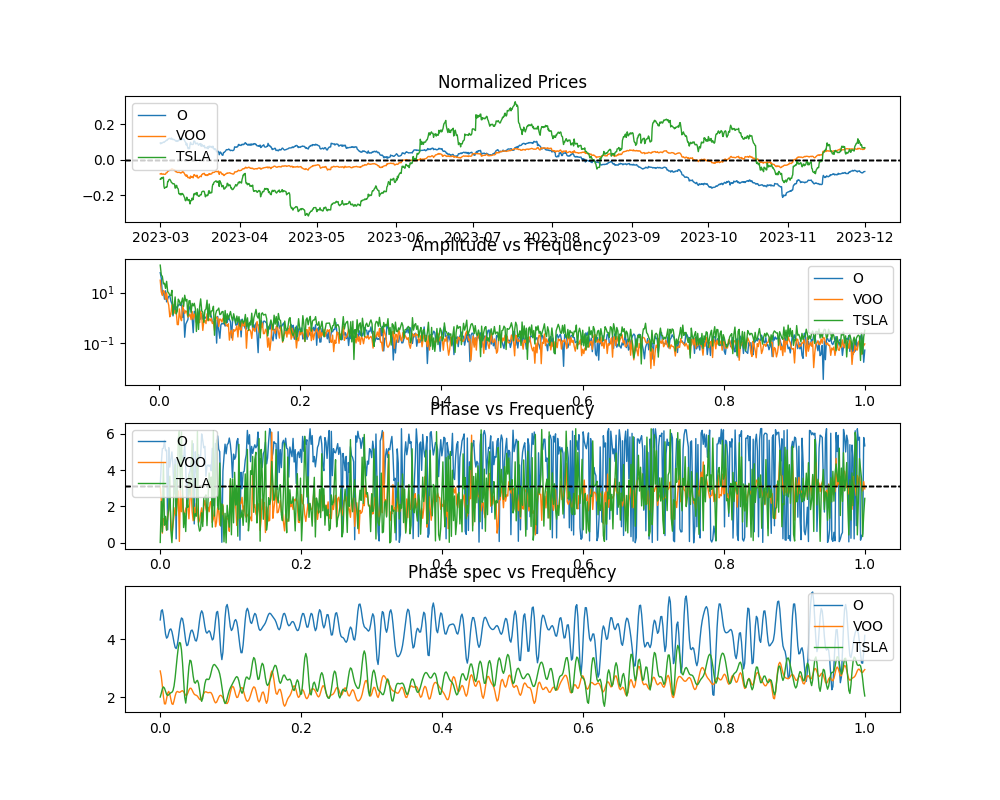

In [161]:
plt.figure(figsize=(10, 8))
plt.tight_layout()
plt.subplots_adjust(hspace=0.3)

tickers = [
    ['O', '2023-03-01', '2023-12-01', '1h'],
    ['VOO', '2023-03-01', '2023-12-01', '1h'],
    ['TSLA', '2023-03-01', '2023-12-01', '1h'],
]
for ticker in tickers:
    prices = np.array(yf.Ticker(ticker[0]).history(start=ticker[1], end=ticker[2], interval=ticker[3])['Close'])
    prices = prices[~np.isnan(prices)]
    prices = (prices - prices.mean()) / prices.mean()
    # prices -= 1

    nyquist_freq = len(prices) // 2
    spectrum = np.fft.fft(prices)[:nyquist_freq]

    ticker_str = ticker[0]

    plt.subplot(411)
    start_date = datetime.strptime(ticker[1], '%Y-%m-%d')
    end_date = datetime.strptime(ticker[2], '%Y-%m-%d')
    num_dates = len(prices)
    date_array = np.linspace(start_date.timestamp(), end_date.timestamp(), num_dates)
    date_objects = [datetime.fromtimestamp(ts) for ts in date_array]
    plt.plot(date_objects, prices, label=ticker_str, linewidth=1)
    plt.axhline(y=0, color='k', linestyle='--', linewidth=1)
    plt.title('Normalized Prices')
    plt.legend()

    x = np.linspace(0, 1, nyquist_freq)

    plt.subplot(412)
    plt.plot(x[1:], np.abs(spectrum)[1:], label=ticker_str, linewidth=1)
    plt.title('Amplitude vs Frequency')
    plt.yscale('log')
    plt.legend()

    plt.subplot(413)
    phases = np.angle(spectrum)
    phases = np.angle(spectrum) % (2*np.pi)
    plt.plot(x, phases, label=ticker_str, linewidth=1)
    plt.axhline(y=np.pi, color='k', linestyle='--', linewidth=1)
    plt.title('Phase vs Frequency')
    plt.legend()

    plt.subplot(414)
    # phase_spec = np.fft.fft(phases)
    phase_spec = np.fft.fft(phases)
    phase_spec[100:] = 0
    phase_lpf = np.fft.ifft(phase_spec)

    plt.plot(x, np.abs(phase_lpf), label=ticker_str, linewidth=1)
    # plt.axhline(y=np.pi, color='k', linestyle='--', linewidth=1)
    plt.title('Phase spec vs Frequency')
    # plt.yscale('log')
    plt.legend()

In [148]:
import numpy as np

# Generate example noisy data
np.random.seed(0)
true_mean = 0
true_std_dev = 0.5
data_size = 100
noise = np.random.normal(true_mean, true_std_dev, size=data_size)

# Estimate parameters of the noise model
estimated_mean = np.mean(noise)
estimated_std_dev = np.std(noise)

print(f"True Mean of Noise: {true_mean}, True Standard Deviation of Noise: {true_std_dev}")
print(f"Estimated Mean of Noise: {estimated_mean}, Estimated Standard Deviation of Noise: {estimated_std_dev}")


True Mean of Noise: 0, True Standard Deviation of Noise: 0.5
Estimated Mean of Noise: 0.0299040077672425, Estimated Standard Deviation of Noise: 0.5039411223582898


0.7969280266853302
10.0


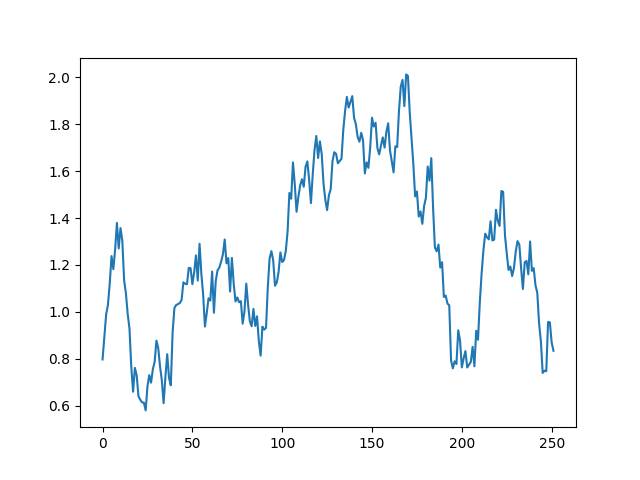

In [38]:
T = len(prices) #number of time steps
n = nyquist_freq #number of fourier terms
# As = 1 / np.arange(1,n+1) #amplitudes of fourier terms
As = np.abs(spectrum) #amplitudes of fourier terms
start_price = prices[0]

thresS = 1
thresB = -1
sell_max = 20
buy_max= 20

thetas = np.random.uniform(0, 2*pi, size=n) #phases of fourier terms

offset = -2*pi/T*sum(As*np.sin(thetas)) + start_price

last_trans = start_price
invest = 0 #shares
cash = 10 

sell_log = []
buy_log = []

P = np.zeros(T)
for k in range(T):
    t = 2*pi*k/T
    for i in range(n):
        P[k] += As[i]*sin(i*t + thetas[i])
    P[k] *= 2*pi/T
    P[k] += offset

    if(P[k] > last_trans + thresS and invest > 0):
        sell_amt = min(sell_max, invest*P[k])
        invest -= sell_amt/P[k]
        cash += sell_amt
        sell_log.append(k)
        print(f"sell {sell_amt/P[k]} shares at {P[k]} for ${sell_amt}, cash={round(cash,2)}, invest={round(invest,2)}")
        last_trans = P[k]
    if(P[k] < last_trans + thresB and cash > 0):
        buy_amt = min(buy_max, cash)
        invest += buy_amt/P[k]
        cash -= buy_amt
        buy_log.append(k)
        print(f"buy {buy_amt/P[k]} shares at {P[k]} for -${buy_amt}, cash={round(cash,2)}, invest={round(invest,2)}")
        last_trans = P[k]

plt.figure()
plt.plot(P)
for k in sell_log:
    plt.plot(k, P[k], 'go')
for k in buy_log:
    plt.plot(k, P[k], 'ro')

print(f"{P[0]}")
print(cash + invest*P[-1])

Average of money-log: -3.0592494851077237


Text(0, 0.5, 'Frequency')

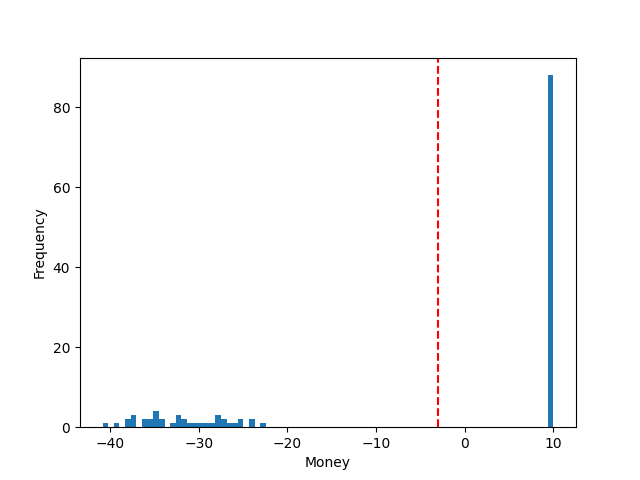

In [33]:
T = len(prices) #number of time steps
n = nyquist_freq #number of fourier terms
# As = 1 / np.arange(1,n+1) #amplitudes of fourier terms
As = np.abs(spectrum) #amplitudes of fourier terms
start_price = prices[0]

thresS = 1
thresB = -1
sell_max = 20
buy_max= 20

trials = 2**7
thetass = qmc.Sobol(d=n).random(trials) * 2*pi

money_log = []
for trial in range(trials):
    # thetas = np.random.uniform(0, 2*pi, size=n) #phases of fourier terms
    thetas = thetass[trial]

    offset = -2*pi/T*sum(As*np.sin(thetas)) + start_price

    last_trans = start_price
    invest = 0 #shares
    cash = 10


    P = np.zeros(T)
    for k in range(T):
        t = 2*pi*k/T
        for i in range(n):
            P[k] += As[i]*sin(i*t + thetas[i])
        P[k] *= 2*pi/T
        P[k] += offset

        if(P[k] > last_trans + thresS and invest > 0):
            sell_amt = min(sell_max, invest*P[k])
            invest -= sell_amt/P[k]
            cash += sell_amt
            last_trans = P[k]
        if(P[k] < last_trans + thresB and cash > 0):
            buy_amt = min(buy_max, cash)
            invest += buy_amt/P[k]
            cash -= buy_amt
            last_trans = P[k]

    money_log.append(cash + invest*P[-1])
# money_log = np.array(money_log)

money_log = [x for x in money_log if (x - np.mean(money_log)) / np.std(money_log) < 3]

average_money_log = sum(money_log) / len(money_log)
print(f"Average of money-log: {average_money_log}")

plt.figure()
plt.hist(money_log, bins=80)
plt.axvline(x=average_money_log, color='r', linestyle='--')

plt.xlabel('Money')
plt.ylabel('Frequency')